# Sequence restoration with Latent Diffusion Models

In [1]:
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline

import os

import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\Shadow\anaconda3\envs\ldm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's also check what type of GPU we've got.

In [2]:
import os

ROOT_PATH = "C:/Users/Shadow/Documents/ImSeqCond/"
#os.chdir("/home/alban/ImSeqCond/latent-diffusion/")
os.chdir(os.path.join(ROOT_PATH, "latent-diffusion/"))

Load it.

In [3]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt=None):
    model = instantiate_from_config(config.model)
    
    if ckpt is not None:
        print(f"Loading model from {ckpt}")
        pl_sd = torch.load(ckpt)#, map_location="cpu")
        sd = pl_sd["state_dict"]
        m, u = model.load_state_dict(sd, strict=False)
    else:
        print("Instantiated model from config")
        
    model.cuda()
    model.eval()
    return model

cond_key = 'label'
#cond_key = 'LR_image'

model_folder = os.path.join(ROOT_PATH, "latent-diffusion/logs_saved/2024-01-18T22-34-24_config_siar_recon")
#model_folder = "/home/alban/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T15-15-42_config_siar_recon"
checkpoint = "epoch=000048.ckpt"

files = os.listdir(os.path.join(model_folder, "configs"))
config_file = ""
for file in files:
    if file.endswith("project.yaml"):
        config_file = file
        break

if config_file == "":
    raise ValueError("No config file found")

def get_model():
    config = OmegaConf.load(os.path.join(model_folder, 'configs', config_file))
    model = load_model_from_config(config, os.path.join(model_folder, "checkpoints", checkpoint))
    return model

In [4]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

# count model parameters
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"Model has {params/1e6:.2f}M parameters")

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Loading model from C:/Users/Shadow/Documents/ImSeqCond/latent-diffusion/logs_saved/2024-01-18T22-34-24_config_siar_recon\checkpoints\epoch=000048.ckpt
Model has 114.54M parameters


In [5]:
# Load some custom data
from ldm.data.siar import SIAR

dataset = SIAR(os.path.join(ROOT_PATH, "data/SIAR"), set_type='val', resolution=256, max_sequence_size=10) #, downscale_f=4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

Wrong images excluded


In [6]:
# Find the index of an image in the dataset

""" for i in range(len(dataset)):
    if dataset[i]['name'] == "7139":
        print(i)
        break """

' for i in range(len(dataset)):\n    if dataset[i][\'name\'] == "7139":\n        print(i)\n        break '

And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

c:\Users\Shadow\anaconda3\envs\ldm\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


rendering 6 examples of images '10089' in 20 steps and using s=1.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


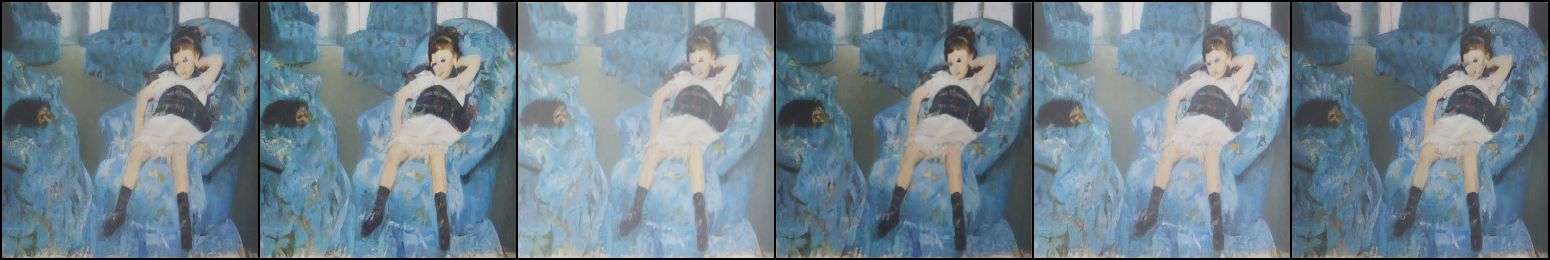

In [7]:
i = 10

images_indexes = [i]
n_samples_per_image = 6

ddim_steps = 20
ddim_eta = 1.0
scale = 1# for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        """ uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.zeros(n_samples_per_image, 3, 64, 64).cuda().to(model.device)}
            ) """
        
        uc = model.get_learned_conditioning(
            torch.zeros(n_samples_per_image, 3, 4, 256, 256).cuda().to(model.device)
            )

        for image_index in images_indexes:
            print(f"rendering {n_samples_per_image} examples of images '{dataset[image_index]['name']}' in {ddim_steps} steps and using s={scale:.2f}.")
            
            if cond_key == 'LR_image':
                xc = rearrange(torch.tensor(dataset[image_index]['LR_image']), 'h w c -> c h w').unsqueeze(0).repeat(n_samples_per_image, 1, 1, 1)
            elif cond_key == 'label':
                xc = rearrange(torch.tensor(dataset[image_index][cond_key]), 's h w c -> c s h w').unsqueeze(0).repeat(n_samples_per_image, 1, 1, 1, 1)
            else:
                raise ValueError(f"Unknown cond_key '{cond_key}'")

            c = model.get_learned_conditioning(xc.to(model.device))

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_image,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)
 

# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_image)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [8]:
def plot_image(data, predict=None):
    """ For a single data point, plot the ground truth image, the input images and the predicted image
    Args:
        gt (torch.tensor): ground truth image
        input (torch.tensor): input images
        predict (torch.tensor): predicted image
    """
    gt, input = data['data'], data['label']
    
    label_images = data['label'].shape[0]
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 10))

    axes[0, 0].imshow(gt)
    axes[0, 0].set_title("Ground truth")
    
    for i in range(label_images):
        axes[i//5, i%5 + 1].imshow(input[i])
        axes[i//5, i%5 + 1].set_title("Input " + str(i+1))
        
    if predict is not None:
        axes[1, 0].imshow(predict)
        axes[1, 0].set_title("Predicted")
        
    plt.show()

In [9]:
def prepare_for_plot(data, all_samples=None):
    
    data_prepared = dict()
    for key, value in data.items():
        if key in ['data', 'label']:
            data_prepared[key] = (value + 1) / 2
    
    predict_prepared = rearrange(all_samples[0][0], 'c h w -> h w c')
    #predict_prepared = (predict_prepared + 1) / 2
    predict_prepared = predict_prepared.cpu().detach().numpy()
    
    return data_prepared, predict_prepared

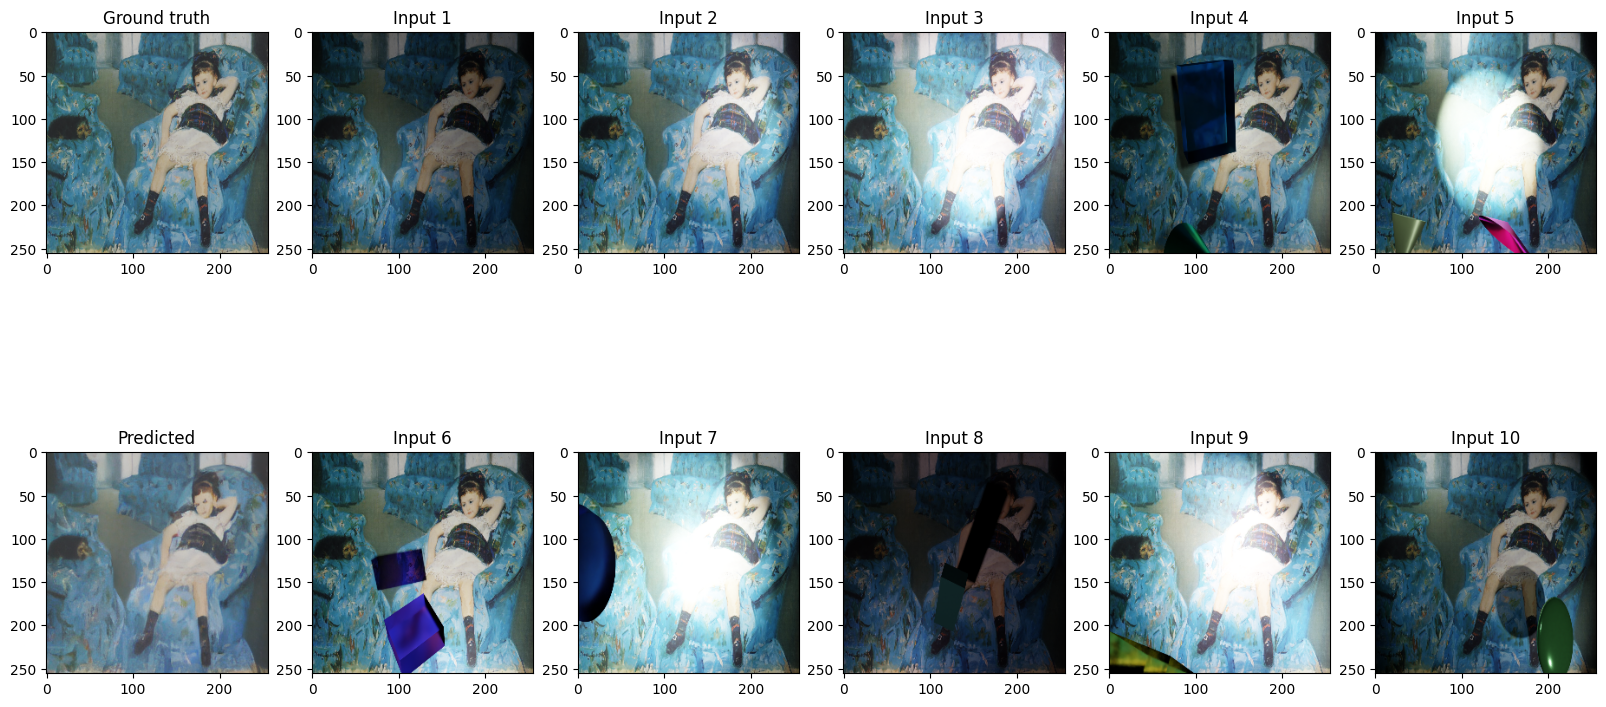

In [10]:
plot_image(*prepare_for_plot(dataset[i], all_samples))

In [11]:
# STUDY OF THE LATENT SPACE

""" cond = c[0]

# convert cond in 0, 1
cond = (cond - cond.min()) / (cond.max() - cond.min())
cond = rearrange(cond, 'c h w -> h w c')
cond = cond.detach().cpu().numpy()

cond_decode = model.decode_first_stage(c[0].unsqueeze(0))

cond_decode = torch.clamp((cond_decode+1.0)/2.0,
                                        min=0.0, max=1.0)
cond_decode = rearrange(cond_decode.squeeze(), 'c h w -> h w c')
cond_decode = cond_decode.detach().cpu().numpy()


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(cond)
axes[0].set_title("Cond in latent space")

axes[1].imshow(cond_decode)
axes[1].set_title("Cond in pixel space") """

' cond = c[0]\n\n# convert cond in 0, 1\ncond = (cond - cond.min()) / (cond.max() - cond.min())\ncond = rearrange(cond, \'c h w -> h w c\')\ncond = cond.detach().cpu().numpy()\n\ncond_decode = model.decode_first_stage(c[0].unsqueeze(0))\n\ncond_decode = torch.clamp((cond_decode+1.0)/2.0,\n                                        min=0.0, max=1.0)\ncond_decode = rearrange(cond_decode.squeeze(), \'c h w -> h w c\')\ncond_decode = cond_decode.detach().cpu().numpy()\n\n\nfig, axes = plt.subplots(1, 2, figsize=(20, 10))\n\naxes[0].imshow(cond)\naxes[0].set_title("Cond in latent space")\n\naxes[1].imshow(cond_decode)\naxes[1].set_title("Cond in pixel space") '

In [12]:
from benchmark import Benchmark

class BenchmarkLDM(Benchmark):
    
    def __init__(self, model, dataloader, mse=True, clip=False, lpips=False, cond_key='label'):
        super().__init__(model, dataloader, mse, clip, lpips, cond_key)
    
    def sample(self, data, ddim_steps=20, ddim_eta=1.0, scale=1):
        """ Method used to sample from the model with the data as conditionning 
            Args:
                data (torch.tensor): conditionning data. size: (batch_size, 3, W, H) or (batch_size, 10, 3, W, H)
            Output:
                torch.tensor: restored image. size: (batch_size, 3, W, H)
        """

        uc = self.model.get_learned_conditioning(
            torch.zeros(data.shape[0], 3, 4, 256, 256).cuda().to(self.model.device)
            )
        
        if self.cond_key == 'LR_image':
            xc = rearrange(torch.tensor(data), 'b h w c -> b c h w')
        elif self.cond_key == 'label':
            xc = rearrange(torch.tensor(data), 'b s h w c -> b c s h w')
        else:
            raise ValueError(f"Unknown cond_key '{cond_key}'")

        c = self.model.get_learned_conditioning(xc.to(self.model.device))

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=data.shape[0],
                                            shape=[3, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=scale,
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)

        x_samples_ddim = self.model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                        min=0.0, max=1.0)
    
        return x_samples_ddim
    

cuda:0


c:\users\shadow\documents\imseqcond\latent-diffusion\src\clip\clip\clip.py:24: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [13]:
benchmark = BenchmarkLDM(model, dataloader, mse=True, clip=True, lpips=True, cond_key=cond_key)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\Users\Shadow\anaconda3\envs\ldm\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [14]:
results = benchmark.evaluate()

Evaluating model on metrics mse, clip, lpips


  0%|          | 0/361 [00:00<?, ?it/s]c:\Users\Shadow\Documents\ImSeqCond\latent-diffusion\scripts\benchmark.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  im = torch.tensor(data['data']).permute(0, 3, 1, 2).to(device)
C:\Users\Shadow\AppData\Local\Temp\ipykernel_5808\1528962894.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xc = rearrange(torch.tensor(data), 'b s h w c -> b c s h w')


Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  0%|          | 1/361 [00:05<34:35,  5.76s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|          | 2/361 [00:10<32:29,  5.43s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|          | 3/361 [00:15<30:46,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|          | 4/361 [00:20<30:32,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  1%|▏         | 5/361 [00:25<30:24,  5.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 6/361 [00:31<30:14,  5.11s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 7/361 [00:36<30:10,  5.11s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 8/361 [00:41<30:02,  5.11s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 9/361 [00:46<29:54,  5.10s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 10/361 [00:51<29:56,  5.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 11/361 [00:56<30:08,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 12/361 [01:02<30:09,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▎         | 13/361 [01:07<29:57,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 14/361 [01:12<29:46,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 15/361 [01:17<29:38,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 16/361 [01:22<29:35,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  5%|▍         | 17/361 [01:27<29:40,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  5%|▍         | 18/361 [01:32<29:33,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  5%|▌         | 19/361 [01:38<30:05,  5.28s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 20/361 [01:43<30:09,  5.31s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 21/361 [01:49<29:56,  5.28s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 22/361 [01:54<29:54,  5.29s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  6%|▋         | 23/361 [01:59<29:42,  5.27s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 24/361 [02:04<29:27,  5.24s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 25/361 [02:09<29:13,  5.22s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 26/361 [02:15<29:04,  5.21s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 27/361 [02:20<28:55,  5.20s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 28/361 [02:25<28:46,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 29/361 [02:30<28:37,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 30/361 [02:35<28:30,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▊         | 31/361 [02:40<28:28,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 32/361 [02:46<28:22,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 33/361 [02:51<28:11,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 34/361 [02:56<28:03,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 10%|▉         | 35/361 [03:01<27:54,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 10%|▉         | 36/361 [03:06<27:49,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 10%|█         | 37/361 [03:11<27:45,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 38/361 [03:16<27:43,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 39/361 [03:22<27:36,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 40/361 [03:27<27:37,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 11%|█▏        | 41/361 [03:32<27:39,  5.19s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 42/361 [03:37<27:31,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 43/361 [03:42<27:23,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 44/361 [03:48<27:19,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 45/361 [03:53<27:12,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 46/361 [03:58<27:08,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 47/361 [04:03<27:02,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 48/361 [04:08<26:58,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▎        | 49/361 [04:13<26:53,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 50/361 [04:19<26:48,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 51/361 [04:24<26:44,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 52/361 [04:29<26:36,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 15%|█▍        | 53/361 [04:34<26:27,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 15%|█▍        | 54/361 [04:39<26:23,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 15%|█▌        | 55/361 [04:44<26:18,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 56/361 [04:49<26:15,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 57/361 [04:55<26:07,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 58/361 [05:00<26:01,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 16%|█▋        | 59/361 [05:05<25:58,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 60/361 [05:10<25:59,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 61/361 [05:15<25:55,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 62/361 [05:20<25:43,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 63/361 [05:26<25:35,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 64/361 [05:31<25:26,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 65/361 [05:36<25:21,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 66/361 [05:41<25:15,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▊        | 67/361 [05:46<25:09,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 68/361 [05:51<25:07,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 69/361 [05:56<25:02,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 70/361 [06:02<24:59,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|█▉        | 71/361 [06:07<24:52,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|█▉        | 72/361 [06:12<24:49,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|██        | 73/361 [06:17<24:43,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 20%|██        | 74/361 [06:22<24:39,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 75/361 [06:27<24:32,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 76/361 [06:33<24:31,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 21%|██▏       | 77/361 [06:38<24:26,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 78/361 [06:43<24:22,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 79/361 [06:48<24:19,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 80/361 [06:53<24:10,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 81/361 [06:58<24:06,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 82/361 [07:04<23:57,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 83/361 [07:09<23:47,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 84/361 [07:14<23:42,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▎       | 85/361 [07:19<23:38,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 86/361 [07:24<23:31,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 87/361 [07:29<23:25,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 88/361 [07:34<23:21,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▍       | 89/361 [07:39<23:18,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▍       | 90/361 [07:45<23:13,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▌       | 91/361 [07:50<23:07,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 25%|██▌       | 92/361 [07:55<23:03,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 93/361 [08:00<22:59,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 94/361 [08:05<22:59,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 26%|██▋       | 95/361 [08:10<22:54,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 96/361 [08:16<22:47,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 97/361 [08:21<22:39,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 98/361 [08:26<22:34,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 99/361 [08:31<22:29,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 100/361 [08:36<22:21,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 101/361 [08:41<22:16,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 102/361 [08:46<22:09,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▊       | 103/361 [08:51<22:05,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 104/361 [08:57<22:12,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 105/361 [09:02<22:20,  5.24s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 106/361 [09:08<22:39,  5.33s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|██▉       | 107/361 [09:13<22:32,  5.32s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|██▉       | 108/361 [09:18<22:11,  5.26s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|███       | 109/361 [09:23<21:56,  5.22s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 30%|███       | 110/361 [09:28<21:49,  5.22s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 111/361 [09:34<21:37,  5.19s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 112/361 [09:39<21:33,  5.20s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 31%|███▏      | 113/361 [09:44<21:21,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 114/361 [09:49<21:12,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 115/361 [09:54<21:05,  5.15s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 116/361 [09:59<20:56,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 117/361 [10:04<20:48,  5.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 118/361 [10:10<20:48,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 119/361 [10:15<20:42,  5.14s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 120/361 [10:20<20:35,  5.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▎      | 121/361 [10:25<20:27,  5.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 122/361 [10:30<20:19,  5.10s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 123/361 [10:35<20:16,  5.11s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 124/361 [10:40<20:08,  5.10s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▍      | 125/361 [10:45<20:03,  5.10s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▍      | 126/361 [10:50<19:58,  5.10s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▌      | 127/361 [10:55<19:56,  5.11s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 35%|███▌      | 128/361 [11:01<19:49,  5.10s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 129/361 [11:06<19:46,  5.11s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 130/361 [11:11<19:40,  5.11s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 36%|███▋      | 131/361 [11:16<19:39,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 132/361 [11:21<19:33,  5.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 133/361 [11:26<19:27,  5.12s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 134/361 [11:31<19:25,  5.13s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 135/361 [11:37<19:25,  5.16s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 136/361 [11:42<19:23,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 137/361 [11:47<19:19,  5.17s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 138/361 [11:52<19:14,  5.18s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▊      | 139/361 [11:58<19:24,  5.25s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 140/361 [12:03<19:38,  5.33s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 141/361 [12:09<19:53,  5.42s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 142/361 [12:14<19:55,  5.46s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|███▉      | 143/361 [12:20<20:00,  5.51s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|███▉      | 144/361 [12:25<19:57,  5.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|████      | 145/361 [12:31<19:58,  5.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 40%|████      | 146/361 [12:36<19:47,  5.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 147/361 [12:42<19:41,  5.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 148/361 [12:47<19:33,  5.51s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 41%|████▏     | 149/361 [12:53<19:30,  5.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 150/361 [12:59<19:30,  5.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 151/361 [13:04<19:16,  5.51s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 152/361 [13:10<19:09,  5.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 153/361 [13:15<19:03,  5.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 154/361 [13:20<18:53,  5.48s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 155/361 [13:26<18:47,  5.47s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 156/361 [13:31<18:37,  5.45s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 157/361 [13:37<18:28,  5.43s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 158/361 [13:42<18:25,  5.44s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 159/361 [13:48<18:19,  5.44s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 160/361 [13:53<18:26,  5.51s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 45%|████▍     | 161/361 [13:59<18:19,  5.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 45%|████▍     | 162/361 [14:04<18:14,  5.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 45%|████▌     | 163/361 [14:10<18:06,  5.49s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 45%|████▌     | 164/361 [14:15<18:01,  5.49s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 46%|████▌     | 165/361 [14:21<17:50,  5.46s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 46%|████▌     | 166/361 [14:26<17:47,  5.47s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 46%|████▋     | 167/361 [14:32<17:44,  5.49s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 168/361 [14:37<17:51,  5.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 169/361 [14:43<17:42,  5.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 170/361 [14:48<17:43,  5.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 171/361 [14:54<17:32,  5.54s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 172/361 [14:59<17:25,  5.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 173/361 [15:05<17:16,  5.51s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 174/361 [15:10<17:09,  5.51s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 175/361 [15:16<17:03,  5.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 49%|████▉     | 176/361 [15:21<16:54,  5.48s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 49%|████▉     | 177/361 [15:27<16:50,  5.49s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 49%|████▉     | 178/361 [15:32<16:46,  5.50s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 50%|████▉     | 179/361 [15:38<16:47,  5.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 50%|████▉     | 180/361 [15:44<16:40,  5.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 50%|█████     | 181/361 [15:49<16:35,  5.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 50%|█████     | 182/361 [15:55<16:28,  5.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 51%|█████     | 183/361 [16:00<16:22,  5.52s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 51%|█████     | 184/361 [16:06<16:19,  5.53s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 51%|█████     | 185/361 [16:11<16:20,  5.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 186/361 [16:17<16:12,  5.56s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 187/361 [16:22<16:10,  5.58s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 188/361 [16:28<16:04,  5.58s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 189/361 [16:34<15:58,  5.57s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 190/361 [16:39<15:49,  5.55s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 191/361 [16:45<15:51,  5.60s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 192/361 [16:50<15:49,  5.62s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 193/361 [16:56<15:37,  5.58s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 54%|█████▎    | 194/361 [17:02<15:46,  5.67s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 54%|█████▍    | 195/361 [17:08<15:47,  5.71s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 54%|█████▍    | 196/361 [17:13<15:34,  5.66s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 55%|█████▍    | 197/361 [17:19<15:27,  5.65s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 55%|█████▍    | 198/361 [17:24<15:19,  5.64s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 55%|█████▌    | 199/361 [17:30<15:15,  5.65s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 55%|█████▌    | 200/361 [17:36<15:07,  5.64s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 56%|█████▌    | 201/361 [17:41<15:09,  5.68s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 56%|█████▌    | 202/361 [17:48<15:33,  5.87s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 56%|█████▌    | 203/361 [17:54<15:28,  5.87s/it]

Data shape for DDIM sampling is (4, 3, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


 57%|█████▋    | 204/361 [17:59<15:19,  5.86s/it]

In [ ]:
print(benchmark.results)

import json

print(json.dumps(benchmark.results, indent=4))

In [ ]:
def rescale(data):
    """ Rescale data between 0 and 1 from -1 and 1
        Args:
            data (torch.tensor): data to rescale
        Output:
            torch.tensor: rescaled data
    """
    return {
        'data': (data['data'] + 1) / 2,
        'label': (data['label'] + 1) / 2,
        'name': data['name'],
    }

In [ ]:
# GENERATE SAMPLES

from PIL import Image
import numpy as np

output_folder = os.path.join(model_folder, 'test_predictions_random')

print(output_folder)

for i in range(min(40, len(dataset))):
    
    j = np.random.randint(len(dataset))
    data = dataset[j]
    
    y = data[cond_key]

    predict = benchmark.sample(y[None,...],20)
    #predict = model.predict(y.unsqueeze(0).to(device))
    out = predict.detach().cpu()
    
    out = out[0].transpose(0,1).transpose(1,2)
    
    if os.path.exists(output_folder) == False:
        os.makedirs(output_folder)
        
    # rescale data
    data = rescale(data) # scale between 0 and 1
    
    plot_image(data, out)
    
    out_im = (out.numpy()* 255).astype(np.uint8) # rescale to 0-255
    
    im_pil = Image.fromarray(out_im)
    im_pil.save(os.path.join(output_folder, f'{data["name"]}.png'))